### Jacopo Sala 
### GOFS 3.1: 41-layer HYCOM + NCODA Global 1/12° Reanalysis
GLBb0.08-53.X
#### Date Range: 1994-01-01 to 2015-12-31


In [1]:
import xarray as xr
import csv
import pandas as pd
import pickle
import numpy as np
import os
from datetime import datetime, date, timedelta
import sys
import matplotlib.pyplot as plt
import netCDF4 as nc
import os.path
import webbrowser
import time

In [2]:
# input TC tracks
track_dir = '/Users/jacoposala/Desktop/CU/3.RESEARCH/ARGO_analysis/Inputs/'
basin_list = ['HURDAT_PACIFIC.csv', 'HURDAT_ATLANTIC.csv', 'JTWC_INDIANOCEAN.csv', 'JTWC_SOUTHERNHEMISPHERE.csv', 'JTWC_WESTPACIFIC.csv']
# define start and end years
start_year = 2011 # 2009
end_year = 2015 # 2018
# days_to_save =  [-20, -15, -12 ,-10, -7, -5, -2, 0, 2, 5, 7, 10, 12, 15, 20] # add +- 12, 15, 20 days
days_to_save =  [-5, -2, 0, 2, 5] # add +- 12, 15, 20 days
var_names_download = ['water_temp', 'salinity']
var_names = ['temperature', 'salinity']

HYCOM_dir = '/Users/jacoposala/Desktop/CU/3.RESEARCH/ARGO_analysis/TC_HYCOM/DATA/HYCOM_near_TC_53x_raw_Aug24/'
HYCOM_save_dir = '/Users/jacoposala/Desktop/CU/3.RESEARCH/ARGO_analysis/TC_HYCOM/DATA/HYCOM_near_TC_53x_pkl_Aug24/'
# HYCOM_save_dir = '/Volumes/Backup/HYCOM/DATA/HYCOM_near_TC_53x_pkl_Aug21/'
# HYCOM_dir = '/Volumes/Backup/HYCOM/DATA/HYCOM_near_TC_53x_raw_Aug24/'

# HYCOM_dir_input ='/Volumes/Backup/HYCOM_RAW_DATA/'
download_dir = '/Users/jacoposala/Downloads/'

# old: ftp://ftp.hycom.org//datasets/global/GLBa0.08_rect/data/temp/rarchv.2008_136_00_3zt.nc4 
# new new: http://ncss.hycom.org/thredds/ncss/GLBv0.08/expt_53.X/data/2015?var=salinity&var=water_temp&north=90.0000&west=-180.0000&east=179.9200&south=-80.0000&horizStride=1&time=2015-12-31T09%3A00%3A00Z&vertCoord=&accept=netcdf4

url_prefix='http://ncss.hycom.org/thredds/ncss/GLBv0.08/expt_53.X/data/YEAR'
# file_prefix ='?var=VARIABLE&disableLLSubset=on&disableProjSubset=on&horizStride=1&time='
file_prefix ='?var=VARIABLE&north=30&west=-180.0000&east=179.9200&south=-30&horizStride=1&time='
# time_list = []
file_suffix='Thh%3A00%3A00Z&vertCoord=&addLatLon=true&accept=netcdf4'

# http://ncss.hycom.org/thredds/ncss/GLBv0.08/expt_53.X/data/2015
# ?var=salinity&var=water_temp&north=30&west=-180.0000&east=179.9200&south=-30&horizStride=1&time=2015-12-31T00%3A00%3A00Z&vertCoord=0&addLatLon=true&accept=netcdf4

z_level_star = '0'
file_extension = '.nc4'
hycom_levels = 28 # 28
max_depth_index_sel = 28 #28 # 10 or 11 depth levels 
min_wind_knots = 64
tag_file = 'HYCOM_53X'

In [3]:
# Read forcing
forcing_name = 'df_forcing_2011.csv'
forcing_dir = '/Users/jacoposala/Desktop/CU/3.RESEARCH/ARGO_analysis/TC_HYCOM/'


df_forcing = pd.read_csv(forcing_dir + forcing_name)

# Convert lon from [0,360] to [-180,180]
df_forcing.lon = (df_forcing.lon + 180) % 360 - 180

# Rename columns to match old version
df_forcing.rename(columns={'lat': 'LAT', 'lon': 'LONG', 'wind_speed': 'WIND', 'time': 'DATETIME', 'precipitation': 'PRECIPITATION'}, inplace=True)


In [4]:
# create mask based on start_year
dfs_mask_1 = pd.to_datetime(df_forcing.DATETIME).dt.year>=start_year
# apply mask start_year to df
dfs_1 = df_forcing[dfs_mask_1].reset_index()

# create mask based on end_year
dfs_mask_2 = pd.to_datetime(dfs_1.DATETIME).dt.year<=end_year
# apply mask end_year to df
dfs_select = dfs_1[dfs_mask_2].reset_index()
dfs_select.shape
dfs_select['DATETIME'] = pd.to_datetime(dfs_select['DATETIME'])
dfs_select.to_pickle('dfs_select_forcing.pkl')
# dfs_select

In [5]:
# Keep only rows over the ocean
import globe

# Check if several points are in the ocean
lat = dfs_select.LAT
lon = dfs_select.LONG
is_in_ocean = globe.is_ocean(lat, lon)

# Mask
dfs_select = dfs_select[is_in_ocean]

In [ ]:
dfs_select.PRECIPITATION.hist()

In [ ]:
sum(dfs_select.PRECIPITATION==0)

In [6]:
# Keep only rows with precipitation greater than zero - REMOVE THIS CONDITION
# dfs_select = dfs_select[dfs_select.PRECIPITATION > 0]

# Keep only storms in the tropical region - CHECK WITH DONATA
dfs_select = dfs_select[(dfs_select.LAT > -30) & (dfs_select.LAT < 30)]

# Keep only rows where UTC hour is either 00, 03, 06, 09, 12, 15, 18, 21 (times at which HYCOM data is available)
dfs_select = dfs_select[dfs_select.DATETIME.dt.hour % 3 == 0]

In [7]:
dfs_select

,level_0,index,Unnamed: 0,LAT,LONG,DATETIME,WIND,PRECIPITATION
287,287,287,0,-14.616693,124.568181,2011-01-11 09:00:00,33.618164,0.016177
288,288,288,0,-14.412263,124.568181,2011-01-11 09:00:00,33.722656,0.021102
3756,3756,3756,0,-25.247014,174.681817,2011-01-26 21:00:00,33.504883,0.002518
3765,3765,3765,0,-26.064731,173.249999,2011-01-27 00:00:00,32.989258,0.008583
3794,3794,3794,0,-26.473590,173.659090,2011-01-27 03:00:00,33.095703,0.003107
...,...,...,...,...,...,...,...,...
152816,152816,152816,0,19.114136,-104.931820,2011-10-12 00:00:00,35.311523,0.005630
152827,152827,152827,0,18.296419,-104.318184,2011-10-12 03:00:00,33.231445,0.000085
152828,152828,152828,0,18.500849,-104.318184,2011-10-12 03:00:00,33.687500,0.000325
152829,152829,152829,0,18.500849,-104.113638,2011-10-12 03:00:00,36.553710,0.001047


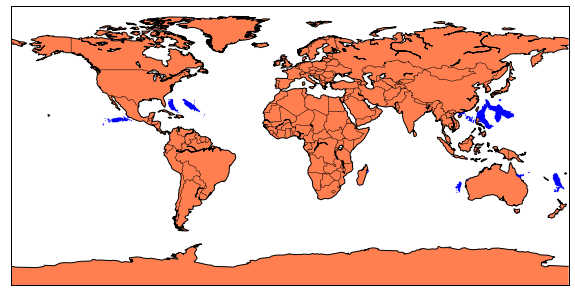

In [8]:
# Quick map of lat and lon to check everything makes sense
from mpl_toolkits.basemap import Basemap

plt.figure(figsize = (10,8))
my_map = Basemap(projection='cyl')

my_map.drawcoastlines()
my_map.drawcountries()
my_map.fillcontinents(color='coral')
my_map.drawmapboundary()

x,y = my_map(dfs_select.LONG, dfs_select.LAT)
my_map.plot(x, y, 'bo', markersize=0.1)
plt.show()

In [9]:
cd /Users/jacoposala/Downloads/


/Users/jacoposala/Downloads


In [10]:
# Define functions

def download_model_dataset_53(date, delta_days, url_prefix, file_prefix, file_suffix, f_dir, file_extension):
    date_to_download = pd.to_datetime(date) + timedelta(days=delta_days)
    year = str(date_to_download)[0:4]
    month = str(date_to_download)[5:7]
    day = str(date_to_download)[8:10]
    hour = str(date_to_download)[11:13]
    date = datetime(int(year), int(month), int(day), int(hour))
    year = f"{int(date_to_download.year):04d}"
    # The year at the beginning of the URL is not always consistent with the actual year of the data being downloaded:
    # Each year "folder" includes files starts at 12 UTC on Jan 1, and goes to 9 UTC of Jan 1 of the following year
    if (date_to_download.month == 1) & (date_to_download.day == 1) & (date_to_download.hour < 12):
        year_prefix = f"{int(date_to_download.year - 1):04d}"
    else:
        year_prefix = year
    month = f"{int(date_to_download.month):02d}"
    day = f"{int(date_to_download.day):02d}"
    file_suffix_hh = file_suffix.replace('hh', hour, 1)
    url = '"' + url_prefix + file_prefix + year + '-' + month + '-' + day + file_suffix_hh + '"'
    name_download = year_prefix + file_prefix + year + '-' + month + '-' + day + file_suffix_hh #'/Users/jacoposala/Downloads/data_' + year + file_extension
    print(name_download)
    name_download = name_download.replace('%3A', ':', 2)
    print(url)
    print(name_download)
    # Download file
    if not os.path.exists(HYCOM_dir + file_prefix + year + month + day + file_suffix_hh + file_extension):
        # Download file
        !wget {url}
        # Wait until the file is downloaded
        while not os.path.exists(name_download):
            time.sleep(1)
        print('Download done!')
        # ...then rename and move file
        if os.path.isfile(name_download):
            os.rename(download_dir + name_download, HYCOM_dir + file_prefix + year + month + day + file_suffix_hh + file_extension)
        else:
            print('Missing ' + name_download)
        print('Renaming or warning done!')
    # Open the file
    dset_day = xr.open_dataset(f'{f_dir}{file_prefix}{year}{month}{day}{file_suffix_hh}{file_extension}')
    # Remove the file
    if os.path.isfile(f'{f_dir}{file_prefix}{year}{month}{day}{file_suffix_hh}{file_extension}'):
        os.remove(f'{f_dir}{file_prefix}{year}{month}{day}{file_suffix_hh}{file_extension}')
    print('Dataset open - ready to return')
    return(dset_day)

def define_array_T_S(bfr_select, days_to_save):
    arr=np.zeros((hycom_levels,len(days_to_save),len(bfr_select)))
    for irow in np.arange(0,len(bfr_select),1):
        n=0
        for i in bfr_select:
            if len(bfr_select[i][irow]) == 1: # if it's not all Nans
                arr[:,n,irow]=bfr_select[i][irow][0][0:max_depth_index_sel]
            else: # if it's all Nans
                arr[:,n,irow]=np.nan
            n = n+1
    return arr


In [11]:
# create a list of unique days only
yymmddhhmmss_str = dfs_select["DATETIME"].dt.strftime('%Y-%m-%d %H:%M:%S').unique()

In [12]:
#date = x
#delta_days=iday
#url_prefix=bfr_url
#file_prefix=bfr_prefix
#file_suffix=file_suffix
#f_dir=HYCOM_dir
#file_extension = file_extension

In [13]:
# y = yymmddhhmmss_str[150:]
# y

In [14]:
# OPTION 2
# On a given day and for a given TC, keep ALL the TC data points

# Main loop
for x in yymmddhhmmss_str: # loop through all unique days 
    print(x)
    # Select TC data for the specific date being considered
    df_bfr_all = dfs_select[dfs_select['DATETIME'].dt.strftime('%Y-%m-%d %H:%M:%S').str.contains(x)]
    df_on_TC_track = df_bfr_all.reset_index(drop=True)
    # Latitude and longitudes of single TCs on this date
    lat = df_on_TC_track['LAT']
    lon = df_on_TC_track['LONG']
    unique_indexes = df_on_TC_track['index']
    for iday in days_to_save: # loop over iday: -5, 0, 5
        for namevar_download,namevar in zip(var_names_download,var_names): # loop over variables (temp or salt)
            column_name = 'day_' + str(iday) + '_' + str(namevar)
            # Initialize new column and populate with NaNs for now
            df_on_TC_track[column_name] = [[np.nan]*hycom_levels]*df_on_TC_track.shape[0]
            
            # Download HYCOM data
            # The year at the beginning of the URL is not always consistent with the actual year of the data being downloaded:
            # Each year "folder" includes files starts at 12 UTC on Jan 1, and goes to 9 UTC of Jan 1 of the following year
            if ((pd.to_datetime(x) + timedelta(days=iday)).month == 1) & ((pd.to_datetime(x) + timedelta(days=iday)).day == 1) & ((pd.to_datetime(x) + timedelta(days=iday)).hour < 12):
                bfr_url = url_prefix.replace('YEAR', str((pd.to_datetime(x) + timedelta(days=iday)).year -1))
            else:
                bfr_url = url_prefix.replace('YEAR', str((pd.to_datetime(x) + timedelta(days=iday)).year))
            bfr_prefix = file_prefix.replace('VARIABLE', str(namevar_download)) 
            bfr_dset = download_model_dataset_53(x, delta_days=iday, url_prefix=bfr_url, file_prefix=bfr_prefix, 
                                            file_suffix=file_suffix, f_dir=HYCOM_dir, file_extension = file_extension)
              
            # Longitude is -180 + 180 already, so no need to re-project
            
            # Loop across all lat-lon where a TC is recorded on this date and find nearest HYCOM data point
            for i in np.arange(len(lat)):
                ilon=lon[i]
                ilat=lat[i]
                i_unique_index = unique_indexes[i]
                # Interpolate HYCOM data
                data_on_track = bfr_dset.interp(lon=[ilon], lat=[ilat])[namevar_download].values.flatten().tolist()
                # Find the relevant TC data point (date, lat and lon being considered)
                mask = (df_on_TC_track['DATETIME'].dt.strftime('%Y-%m-%d %H:%M:%S').str.contains(x)).values & \
                (df_on_TC_track['LONG']==ilon).values & (df_on_TC_track['LAT']==ilat).values & \
                (df_on_TC_track['index']==i_unique_index).values
                # Populate relevant row in df_on_TC_track (if the interpolation gave some not-Nans)
                if sum(np.isnan(data_on_track))!=len(data_on_track):
                    df_on_TC_track.loc[mask,column_name] = [[data_on_track]]
                    #print(df_on_TC_track)
                    
    # Save daily files with HYCOM data near TCs
    index = np.arange(0,len(df_on_TC_track),1)

    for ivar in ['temperature','salinity']:
        lst = []
        for i_dtime in days_to_save:
            lst.append('day_'+str(i_dtime)+'_'+ivar)
        bfr_select = df_on_TC_track[df_on_TC_track.columns.intersection(lst)]   
        bfr = define_array_T_S(bfr_select, days_to_save)
        exec(ivar+'= bfr')
    
    d_xr = xr.Dataset(
        data_vars=dict(
            #ID=(["index"], df_on_TC_track.ID,{'label': 'ID TCs'}),
            longitude=(["index"], df_on_TC_track.LONG),
            latitude=(["index"], df_on_TC_track.LAT),
            time=(["index"], df_on_TC_track.DATETIME),
            wind=(["index"], df_on_TC_track.WIND),
            precipitation=(["index"], df_on_TC_track.PRECIPITATION),
            temperature=(["depth", "delta_time", "index"], temperature ,{'label': 'HYCOM T at TC location'}),
            salinity=(["depth", "delta_time", "index"], salinity,{'label': 'HYCOM S at TC location'}),
        ),
        coords=dict(
            index=index,
            depth=bfr_dset.depth.values[0:max_depth_index_sel],
            delta_time=days_to_save,
        ),
        attrs=dict(description="HYCOM T/S co-located with TCs"),
        )
    with open(HYCOM_save_dir+tag_file+'_'+x[0:4]+'_'+x[5:7]+'_'+x[8:10]+'_'+x[11:13]+'UTC.pkl', 'wb') as handle:
        pickle.dump(d_xr, handle, protocol=pickle.HIGHEST_PROTOCOL)


2011-01-11 09:00:00
2011?var=water_temp&north=30&west=-180.0000&east=179.9200&south=-30&horizStride=1&time=2011-01-06T09%3A00%3A00Z&vertCoord=&addLatLon=true&accept=netcdf4
"http://ncss.hycom.org/thredds/ncss/GLBv0.08/expt_53.X/data/2011?var=water_temp&north=30&west=-180.0000&east=179.9200&south=-30&horizStride=1&time=2011-01-06T09%3A00%3A00Z&vertCoord=&addLatLon=true&accept=netcdf4"
2011?var=water_temp&north=30&west=-180.0000&east=179.9200&south=-30&horizStride=1&time=2011-01-06T09:00:00Z&vertCoord=&addLatLon=true&accept=netcdf4
--2022-08-30 20:34:38--  http://ncss.hycom.org/thredds/ncss/GLBv0.08/expt_53.X/data/2011?var=water_temp&north=30&west=-180.0000&east=179.9200&south=-30&horizStride=1&time=2011-01-06T09%3A00%3A00Z&vertCoord=&addLatLon=true&accept=netcdf4
Resolving ncss.hycom.org... 144.174.97.9
Connecting to ncss.hycom.org|144.174.97.9|:80... connected.
HTTP request sent, awaiting response... 200 200
Length: 113737714 (108M) [application/x-netcdf4]
Saving to: '2011?var=water_te

KeyboardInterrupt: 

In [ ]:
df_on_TC_track